# aim: Ad-hoc classifier of Python 2 vs 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC # not stochastic
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import export_graphviz
import re
from sqlalchemy import create_engine
import pickle
import warnings
#import requests
#from bs4 import BeautifulSoup
#import time
#from fake_useragent import UserAgent
#import sys, os
import flask
import json
from collections import defaultdict

warnings.filterwarnings("ignore")
%matplotlib inline

RANDOM_STATE = 1
TEST_SIZE = 0.3
MYFOLDS = 5

### import cleaned data

In [2]:
with open("cleaned2_data.pkl", 'rb') as picklefile: 
    df_all = pickle.load(picklefile)

In [3]:
X_cols = [col for col in df_all.columns if col not in ['q_id', 'q_user', 'a_id', 'a_user', 'label_col']]
X_cols_label = ['Question Score', 'Question Views', 'Answer Score', 'Asker Reputation', 'Asker Gold Badges', 
    'Asker Silver Badges', 'Asker Bronze Badges', 'Answerer Reputation', 'Answerer Gold Badges', 
    'Answerer Silver Badges', 'Answerer Bronze Badges', 'Array Tag',
    'Beautifulsoup Tag', 'CSV Tag', 'Dataframe Tag', 'Datetime Tag', 'Dictionary Tag', 'Django Tag',
    'Flask Tag', 'Json Tag', 'List Tag', 'Matplotlib Tag', 'Numpy Tag', 'Pandas Tag', 'Python Tag',
    'Regex Tag', 'String Tag', 'Unicode Tag', 'Unit-testing Tag', 'Log Seconds between Question and Answer',
    'Year of Question', 'Month of Question', 'Day of Question', 'Day of Week of Question', 
    'Log Seconds between Question and Present Day', 'Year of Answer',
    'Month of Answer', 'Day of Answer', 'Day of Week of Answer', 'Log Seconds between Answer and Present Day', 
    'Length of Question Title', 'Length of Question', 'Length of Answer']

### holdout set

In [4]:
#sample questions, not rows, b/c one person esp. power users can ask multiple questions 
id_set = df_all[['q_id']].drop_duplicates()
ids, id_holdout = train_test_split(id_set, test_size = TEST_SIZE)

In [5]:
df = df_all.loc[df_all['q_id'].map(lambda x: x in ids['q_id'].tolist())]
df.reset_index(drop = True, inplace = True)
df_holdout = df_all.loc[df_all['q_id'].map(lambda x: x in id_holdout['q_id'].tolist())]
df_holdout.reset_index(drop = True, inplace = True)

X = df[X_cols]
y = df['label_col']

X_holdout = df_holdout[X_cols]
y_holdout = df_holdout['label_col']
# print(df.shape, X.shape, y.shape, df_holdout.shape, X_holdout.shape, y_holdout.shape, 
#       y.shape[0] / y_holdout.shape[0])

In [89]:
#make a tr/ts for plotting ROC curve
trid_for_roc, tsid_for_roc = train_test_split(ids, test_size = TEST_SIZE)

In [92]:
tr_for_roc = df_all.loc[df_all['q_id'].map(lambda x: x in trid_for_roc['q_id'].tolist())]
tr_for_roc.reset_index(drop = True, inplace = True)
ts_for_roc = df_all.loc[df_all['q_id'].map(lambda x: x in tsid_for_roc['q_id'].tolist())]
ts_for_roc.reset_index(drop = True, inplace = True)

X_tr_for_roc = tr_for_roc[X_cols]
y_tr_for_roc = tr_for_roc['label_col']

X_ts_for_roc = ts_for_roc[X_cols]
y_ts_for_roc = ts_for_roc['label_col']
# print(tr_for_roc.shape, X_tr_for_roc.shape, y_tr_for_roc.shape, ts_for_roc.shape, 
#       X_ts_for_roc.shape, y_ts_for_roc.shape, y_tr_for_roc.shape[0] / y_ts_for_roc.shape[0])

### model

In [6]:
metric_cols = ["Accuracy", "Precision", "Recall", "F1", "model"]
def get_metrics(model, X = X, cv = MYFOLDS):
    return [np.mean(cross_val_score(model, X, y, groups = df['q_id'], cv = cv, scoring = make_scorer(accuracy_score))),
          np.mean(cross_val_score(model, X, y, groups = df['q_id'], cv = cv, scoring = make_scorer(precision_score))),
          np.mean(cross_val_score(model, X, y, groups = df['q_id'], cv = cv, scoring = make_scorer(recall_score))),
          np.mean(cross_val_score(model, X, y, groups = df['q_id'], cv = cv, scoring = make_scorer(f1_score)))]

In [7]:
model_metrics_cv5 = pd.DataFrame()

- naiive Bayes

In [8]:
nb = GaussianNB()
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(nb) + ["GaussianNB"]).reshape(1, 5)))
model_metrics_cv5

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB


- stochastic linaer SVM

In [9]:
svm = SGDClassifier(loss = 'hinge', penalty = 'l1', alpha = 0.0001, random_state = RANDOM_STATE)
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(svm) + ["SVM"]).reshape(1, 5)))
model_metrics_cv5

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM


- stochastic SVM with rbf kernel

In [10]:
rbf_X_fun = RBFSampler(gamma = 1, random_state = RANDOM_STATE)
rbf_X_fun.fit(X)
rbf_X = rbf_X_fun.transform(X)

rbf_svm = SGDClassifier(loss = 'hinge', penalty = 'l1', alpha = 0.0001, random_state = RANDOM_STATE)
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(rbf_svm, X = rbf_X) + [r"SVM(RBF)"]).reshape(1, 5)))
model_metrics_cv5
#TODO GridSearchCV

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)


- logistic reg

In [11]:
logr = LogisticRegression()
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(logr) + ["LogisticReg"]).reshape(1, 5)))
model_metrics_cv5

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
0,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg


- logistic reg w LASSO

In [12]:
logr_lasso = LogisticRegression(penalty = 'l1', C = 1)
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(logr_lasso) + [r"LogisticReg(LASSO)"]).reshape(1, 5)))
model_metrics_cv5
#TODO GridSearchCV

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
0,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg
0,0.532725941325,0.453674742412,0.319129438717,0.362155414766,LogisticReg(LASSO)


- knn

In [13]:
knn = KNeighborsClassifier(n_neighbors = 5)
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(knn) + ["KNN(5)"]).reshape(1, 5)))
model_metrics_cv5
#TODO loop thru diff k's

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
0,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg
0,0.532725941325,0.453674742412,0.319129438717,0.362155414766,LogisticReg(LASSO)
0,0.54508635041,0.505904574624,0.545246277205,0.522472922362,KNN(5)


- gboost

In [14]:
gboost = GradientBoostingClassifier()
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(gboost) + ["GBoost"]).reshape(1, 5)))
model_metrics_cv5
#TODO GridSearchCV

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
0,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg
0,0.532725941325,0.453674742412,0.319129438717,0.362155414766,LogisticReg(LASSO)
0,0.54508635041,0.505904574624,0.545246277205,0.522472922362,KNN(5)
0,0.62393117199,0.615563316842,0.482932416953,0.529136991649,GBoost


- rf

In [16]:
mygrid = {"n_estimators": [10, 20, 30, 40], 
          "max_depth": [5, 7, 9, 11, 13],
          "min_samples_split": [2, 0.02],
          "min_samples_leaf": [1, 0.01]
         }
grid_search = GridSearchCV(RandomForestClassifier(), param_grid = mygrid, scoring = make_scorer(f1_score), cv = MYFOLDS)
fit = grid_search.fit(X, y, groups = df['q_id'])
all_result = grid_search.cv_results_
rf_final = grid_search.best_estimator_
print(rf_final)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [17]:
model_metrics_cv5 = model_metrics_cv5.append(pd.DataFrame(np.array(get_metrics(rf_final) + ["RF"]).reshape(1, 5)))
model_metrics_cv5

,0,1,2,3,4
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
0,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
0,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
0,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg
0,0.532725941325,0.453674742412,0.319129438717,0.362155414766,LogisticReg(LASSO)
0,0.54508635041,0.505904574624,0.545246277205,0.522472922362,KNN(5)
0,0.62393117199,0.615563316842,0.482932416953,0.529136991649,GBoost
0,0.651374722656,0.627210522414,0.445589919817,0.533032633883,RF


In [18]:
model_metrics_cv5.columns = metric_cols
model_metrics_cv5.reset_index(inplace = True, drop = True)
model_metrics_cv5

,Accuracy,Precision,Recall,F1,model
0,0.552625343166,0.531306675031,0.0792668957617,0.135600788778,GaussianNB
1,0.529373016765,0.487743565266,0.504009163803,0.432794021555,SVM
2,0.53000200209,0.463880952465,0.181901489118,0.243953568721,SVM(RBF)
3,0.537749705857,0.469282531776,0.246048109966,0.311049608536,LogisticReg
4,0.532725941325,0.453674742412,0.319129438717,0.362155414766,LogisticReg(LASSO)
5,0.54508635041,0.505904574624,0.545246277205,0.522472922362,KNN(5)
6,0.62393117199,0.615563316842,0.482932416953,0.529136991649,GBoost
7,0.651374722656,0.627210522414,0.445589919817,0.533032633883,RF


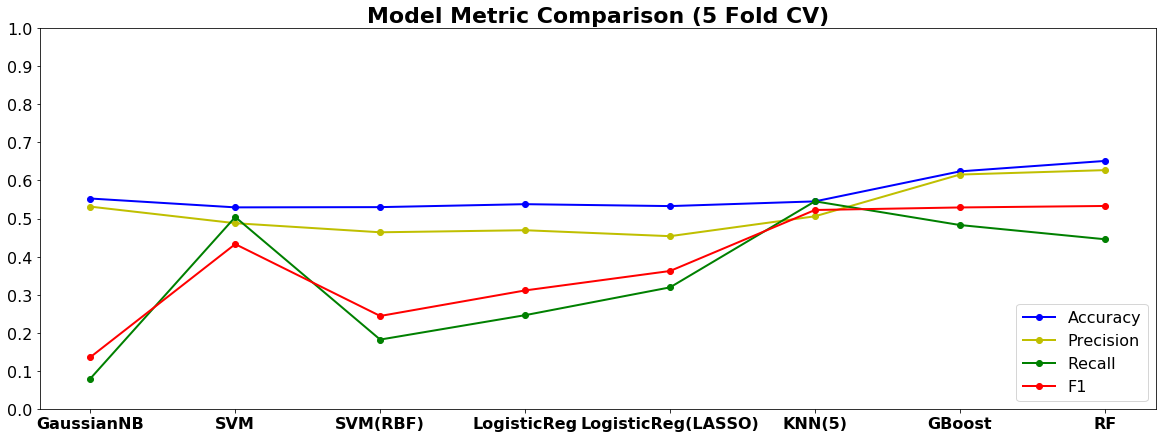

In [121]:
plt.figure(figsize = (20, 7))
plt.plot(model_metrics_cv5.index, model_metrics_cv5['Accuracy'], "b-o", label = 'Accuracy', linewidth = 2)
plt.plot(model_metrics_cv5.index, model_metrics_cv5['Precision'], "y-o", label = 'Precision', linewidth = 2)
plt.plot(model_metrics_cv5.index, model_metrics_cv5['Recall'], "g-o", label = 'Recall', linewidth = 2)
plt.plot(model_metrics_cv5.index, model_metrics_cv5['F1'], "r-o", label = 'F1', linewidth = 2)
plt.xticks(model_metrics_cv5.index, model_metrics_cv5['model'], fontsize = 16, fontweight = 'bold')
plt.ylim([0, 1])
plt.yticks(np.array(range(0, 101, 10)) / 100, fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)
plt.title(r"Model Metric Comparison (5 Fold CV)", fontsize = 22, fontweight = 'bold')
plt.show()

In [93]:
rf_final.fit(X_tr_for_roc, y_tr_for_roc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [97]:
def get_metrics2(X, y, whatdata, final_model = rf_final, mypos_label = 1): #label_col == 1 means it's a Python3 question
    pred = final_model.predict(X)
    accuracy = accuracy_score(y, pred)
    precision = precision_score(y, pred, pos_label = mypos_label) 
    recall = recall_score(y, pred, pos_label = mypos_label)
    f1 = f1_score(y, pred, pos_label = mypos_label)
    
    pred_proba = final_model.predict_proba(X)[:, 1]
    fpr, tpr, thres = roc_curve(y, pred_proba, pos_label = mypos_label)
    auc_value = auc(fpr, tpr)

    mystr = "Random Forest " + whatdata + \
      " accuracy " +  str(format(accuracy, "8.4f")).strip(" ") + \
      " precision " +  str(format(precision, "8.4f")).strip(" ") + \
      " recall " +  str(format(recall, "8.4f")).strip(" ") + \
      " f1 " +  str(format(f1, "8.4f")).strip(" ") + \
      " auc " +  str(format(auc_value, "8.4f")).strip(" ")
    
    return pred, pred_proba, accuracy, precision, recall, f1, fpr, tpr, thres, auc_value, mystr

In [98]:
pred_ts, pred_proba_ts, accuracy_ts, precision_ts, recall_ts, \
f1_ts, fpr_ts, tpr_ts, thres_ts, auc_value_ts, mystr_ts = get_metrics2(X_ts_for_roc, y_ts_for_roc, "testing set")
print(mystr_ts)

Random Forest testing set accuracy 0.6229 precision 0.5936 recall 0.4783 f1 0.5297 auc 0.6494


In [99]:
pred, pred_proba, accuracy, precision, recall, \
f1, fpr, tpr, thres, auc_value, mystr = get_metrics2(X_holdout, y_holdout, "holdout set")
print(mystr)

Random Forest holdout set accuracy 0.6415 precision 0.6972 recall 0.5135 f1 0.5914 auc 0.6842


In [130]:
mystr_cv = "Random Forest " + "5 fold CV" + \
      " accuracy " +  str(format(float(model_metrics_cv5.loc[cond, "Accuracy"]), "8.4f")).strip(" ") + \
      " precision " +  str(format(float(model_metrics_cv5.loc[cond, "Precision"]), "8.4f")).strip(" ") + \
      " recall " +  str(format(float(model_metrics_cv5.loc[cond, "Recall"]), "8.4f")).strip(" ") + \
      " f1 " +  str(format(float(model_metrics_cv5.loc[cond, "F1"]), "8.4f")).strip(" ") + \
      " auc -.----    "
print(mystr_cv)

Random Forest 5 fold CV accuracy 0.6514 precision 0.6272 recall 0.4456 f1 0.5330 auc -.----    


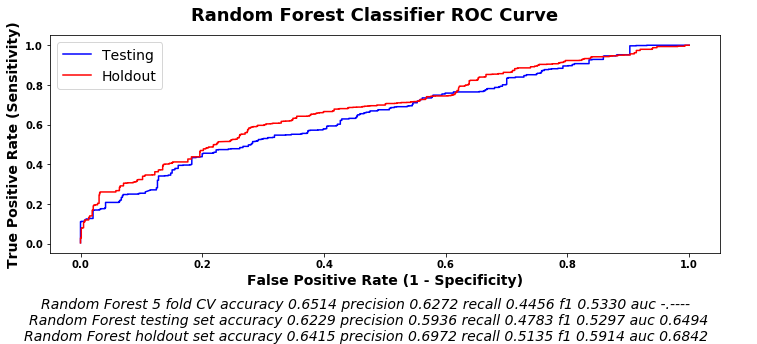

In [148]:
plt.figure(figsize = (12, 4))
plt.plot(fpr_ts, tpr_ts, "b-", label = "Testing")
plt.plot(fpr, tpr, "r-", label = "Holdout")
plt.suptitle("Random Forest Classifier ROC Curve", fontsize = 18, fontweight = 'bold')
plt.title("", fontsize = 4)
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize = 14, fontweight = 'bold')
plt.ylabel("True Positive Rate (Sensitivity)", fontsize = 14, fontweight = 'bold')
plt.annotate(mystr_cv + "\n" + mystr_ts + "\n" + mystr + "\n\n\n", xy=(0.935, 0), xycoords='figure fraction',
            xytext=(0, -45), textcoords='offset points',
            ha = "right", fontsize = 14, style='italic')
plt.yticks(fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.legend(fontsize = 14)
plt.show()

In [156]:
imp = pd.DataFrame(rf_final.feature_importances_, columns = ["imp"])
imp['feat'] = X_cols_label
imp.sort_values('imp', ascending = False, inplace = True)
imp.set_index(np.array(range(len(X_cols_label)))+1, inplace = True)
imp.head(3)

,imp,feat
1,0.078956,Asker Reputation
2,0.069106,Asker Bronze Badges
3,0.068227,Length of Question


In [175]:
pd.crosstab(pd.DataFrame(np.array(y_holdout), columns = ["True"]).iloc[:, 0], \
            pd.DataFrame(np.array(pred), columns = ["Pred"]).iloc[:, 0])

Pred,False,True
True,,
False,1848,545
True,1189,1255


### sandbox

In [ ]:
first_tree = rf[0]

In [ ]:
X.columns[29]

In [ ]:
avg_f_imp = pd.DataFrame(rf.feature_importances_, columns = ["imp"])
avg_f_imp['name'] = X.columns
avg_f_imp.sort_values('imp', ascending = False, inplace = True)
#avg_f_imp

In [ ]:
export_graphviz(first_tree)
first_tree.tree_.

In [ ]:
first_tree.tree_.children_left[0:10]

In [ ]:
first_tree.tree_.children_right[0:10]

In [ ]:
df_all["label_col"].value_counts()

In [ ]:
X.columns

### pickle model

- rf for viz

In [117]:
# print(rf_final)

In [119]:
rf_viz = RandomForestClassifier(n_estimators=40, max_depth=9)
rf_viz.fit(X_tr_for_roc, y_tr_for_roc)
pred_viz, pred_proba_viz, accuracy_viz, precision_viz, recall_viz, \
f1_viz, fpr_viz, tpr_viz, thres_viz, auc_value_viz, mystr_viz = \
get_metrics2(X_ts_for_roc, y_ts_for_roc, "", final_model=rf_viz)
print(mystr_viz)

Random Forest  accuracy 0.6183 precision 0.6013 recall 0.4172 f1 0.4926 auc 0.6407


In [120]:
with open('data_for_viz.pkl', 'wb') as picklefile:
    pickle.dump(rf_viz, picklefile)
    pickle.dump(X_cols_label, picklefile)